In [3]:
import scipy
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [54]:
def save_array_to_nifti1(array, original_img, destination_path, output_name):
    # Transform the array to a nifti image which requires the affine of the original image.
    processed_img = nib.Nifti1Image(array, original_img.affine)
    nib.save(processed_img, os.path.join(destination_path, output_name))

In [39]:
def Stroke_closing(img):
    # used to close stroke prediction image
    new_img = np.zeros_like(img)
    new_img = scipy.ndimage.binary_closing(img, structure=np.ones((2,2,2)))
    return new_img

In [40]:
def get_MaskNet_MNI(model, Dwi_MNI_img, B0_MNI_img):
    # To inference brain mask from MaskNet model
    # model specifies which pre-trained DL model is used to inference
    # Dwi_MNI_img and B0_MNI_img are input images in MNI domain
    
    # Down sampling
    dwi = Dwi_MNI_img[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

    b0 = B0_MNI_img[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]
    x = np.expand_dims(np.concatenate((dwi,b0),axis=3), axis=0)

    # inference
    y_pred = model.predict(x, verbose=0)
    y_pred = (np.squeeze(y_pred)>0.5)*1.0

    
    # the following is post processing of predicted mask by 
    # 1) selecting the major non-zero voxel
    # 2) closing
    # 3) binary fill holes
    # 4) upsampling to high resolution space by (4,4,4)
    
    mask_label, num_features = scipy.ndimage.label(y_pred)
    dilate_mask = (mask_label == scipy.stats.mode(mask_label[mask_label>0].flatten(), keepdims=True)[0][0])*1
    dilate_mask = Stroke_closing(dilate_mask)
    dilate_mask = scipy.ndimage.binary_fill_holes(dilate_mask)
    upsampling_mask = np.repeat(np.repeat(np.repeat(dilate_mask, 4, axis=0), 4, axis=1), 4, axis=2)

    return upsampling_mask

In [27]:
MaskNet_name =  os.path.join("D:\ADS_Algorithm\ADSv1.3\data\Trained_Nets", 'BrainMaskNet.h5')

In [28]:
MaskNet = load_model(MaskNet_name, compile=False)

In [ ]:
mask_MNI_img = get_MaskNet_MNI(MaskNet, Dwi_MNI_img, B0_MNI_img)
mask_raw_img = affine_map.transform_inverse((mask_MNI_img>0.5)*1, interpolation='nearest')
mask_raw_img = (mask_raw_img>0.5)*1.0

if generate_brainmask:
    mask_raw_ImgJ = get_new_NibImgJ(mask_raw_img, Dwi_imgJ, dataType=np.int16)
    nib.save(mask_raw_ImgJ, os.path.join(SubjDir, SubjID + '_Mask.nii.gz'))

In [15]:
nii_dwi_img = nib.load("D:\\pythonscripts_ETIS\\2018-104_01-10087-D0MR_12_SWI_Images_swi3d1r_Normalized.nii.gz")
nii_dwi_data = nii_dwi_img.get_fdata()

In [16]:
nii_dwi_data.shape

(192, 224, 192)

In [17]:
dwi = nii_dwi_data[0::4,0::4,0::4,np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

In [18]:
dwi.shape

(48, 56, 48, 1)

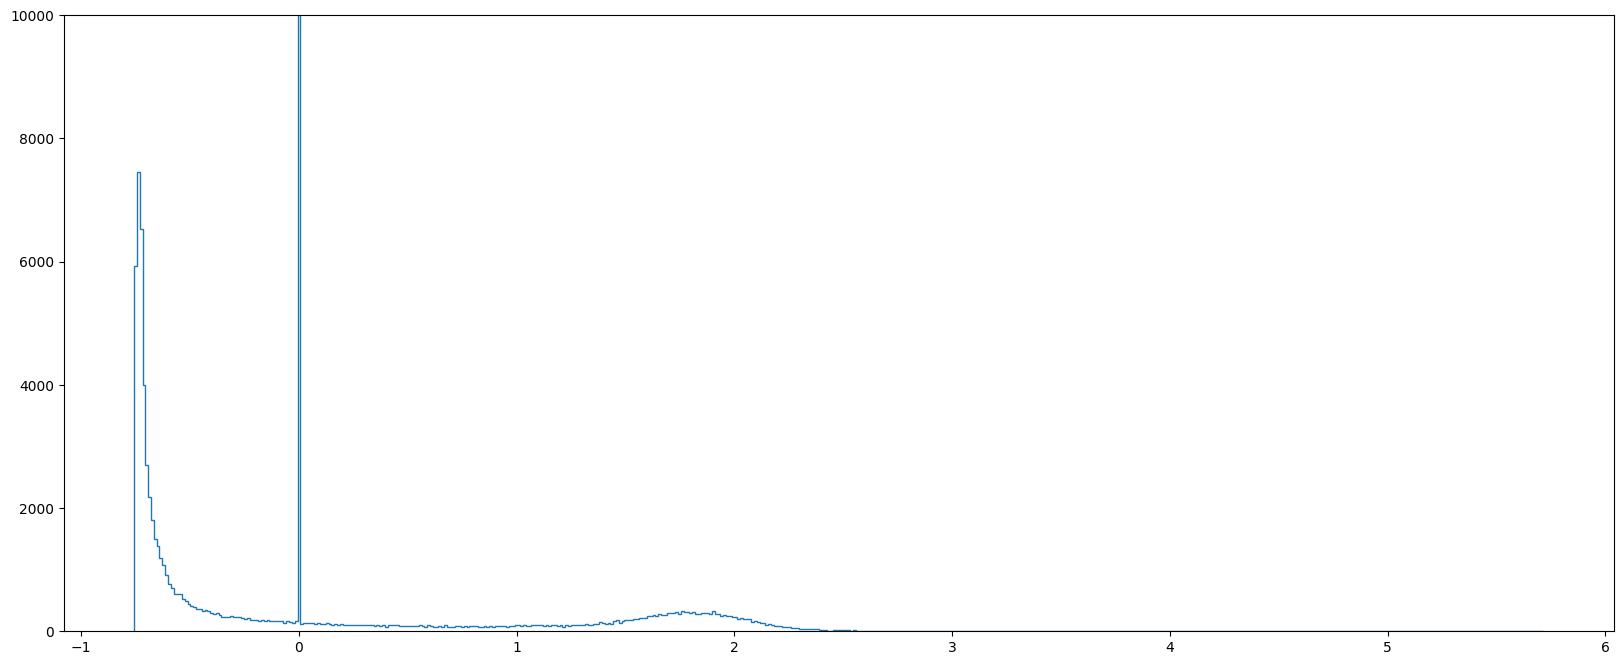

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(dwi.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,10000)
plt.show()

In [22]:
nii_b0_img = nib.load("D:\\pythonscripts_ETIS\\2018-104_01-10087-D0MR_8_TOF_3D_NEW_wo_ARTEFACTS_fl3d1r_t50_Normalized.nii.gz")
nii_b0_data = nii_b0_img.get_fdata()

In [6]:
ref_img = nib.load("D:\\pythonscripts_ETIS\\Reference_Image_SkullStripping\\Reference_DWI_ADS_MNI_Normalized.nii.gz")
ref_img_data = ref_img.get_fdata()

In [88]:
ref = ref_img_data[0::4,0::4,0::4, np.newaxis]

In [8]:
ref_img_data.shape

(192, 224, 192)

In [90]:
ref.shape

(46, 55, 46, 1)

In [23]:
b0 = nii_b0_data[0::4,0::4,0::4, np.newaxis] # Down sample for MaskNet, dim should be [48, 56, 48, 1]

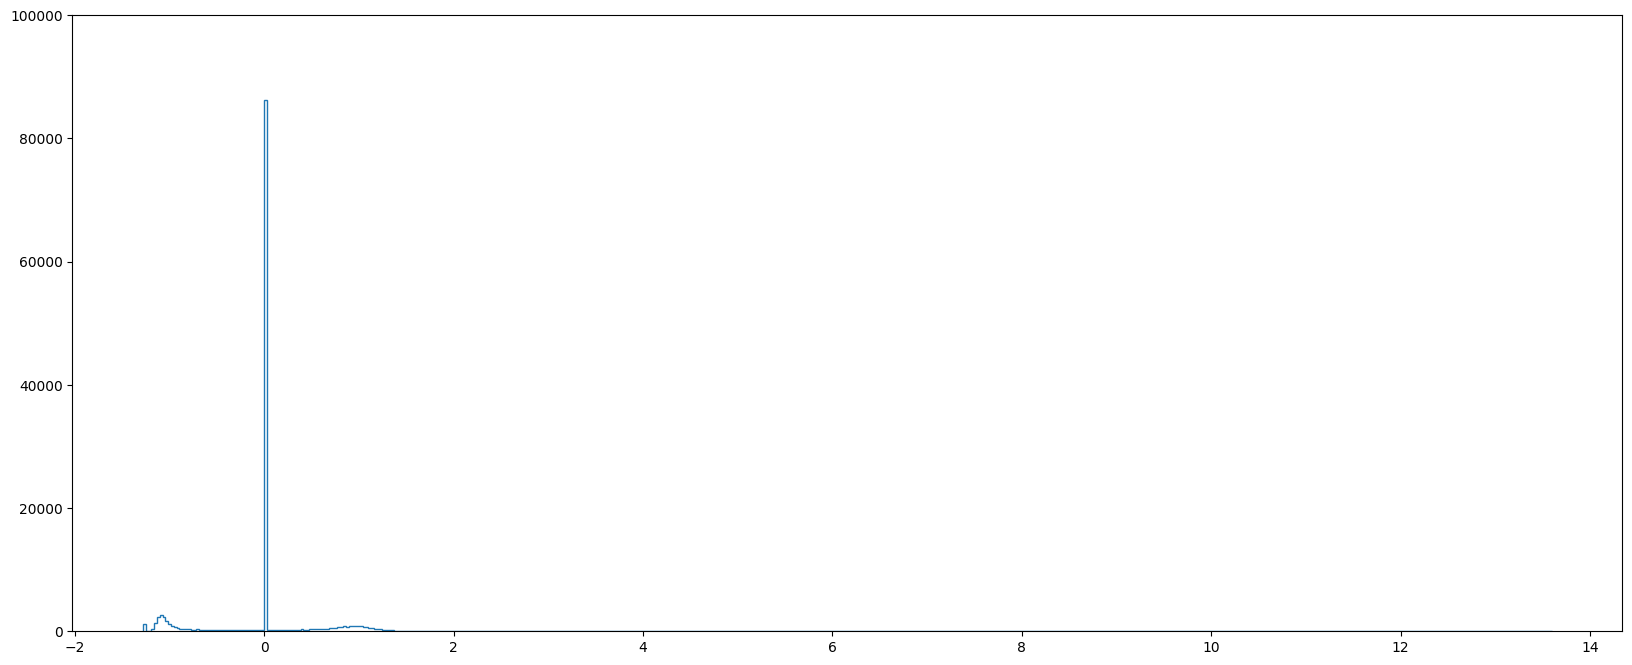

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))
counts, bins = np.histogram(b0.flatten(), bins=500)

plt.hist(bins[:-1], bins, weights=counts, histtype="step")
ax.set_ylim(0,100000)
plt.show()

In [25]:
x = np.expand_dims(np.concatenate((dwi,b0),axis=3), axis=0)

In [29]:
y_pred = MaskNet.predict(x, verbose=0)

In [32]:
y_pred = (np.squeeze(y_pred)>0.5)*1.0

In [42]:
mask_label, num_features = scipy.ndimage.label(y_pred)

In [43]:
dilate_mask = (mask_label == scipy.stats.mode(mask_label[mask_label>0].flatten(), keepdims=True)[0][0])*1    

In [44]:
dilate_mask = Stroke_closing(dilate_mask)

In [45]:
dilate_mask = scipy.ndimage.binary_fill_holes(dilate_mask)

In [46]:
upsampling_mask = np.repeat(np.repeat(np.repeat(dilate_mask, 4, axis=0), 4, axis=1), 4, axis=2)

In [47]:
upsampling_mask.astype("float64")

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [48]:
test_mask = nib.load("D:\\data_ETIS\\MASK\\2018-104_01-10087-D0MR_S12_202312051300_Tours-THROMBMICS-Clot-Segmentation.nii.gz")
test_mask_data = test_mask.get_fdata()

In [55]:
save_array_to_nifti1(upsampling_mask.astype("float64"), nii_dwi_img, "D:\\pythonscripts_ETIS\\", "test_mask.nii.gz")

In [56]:
upsampling_mask.shape

(192, 224, 192)

In [57]:
nii_dwi_img.shape

(192, 224, 192)